## Initial setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)
# tensorflow version used is 2.8.0
import torch
print(torch.__version__)
# torch version used is 1.10+cu111

2.8.0
1.10.0+cu111


In [ ]:
!nvidia-smi

Sun Mar 20 16:57:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Other imports
! pip install tensorflow_addons
! pip install tensorflow_io
! pip install lightgbm
! pip install xgboost
! pip install catboost

import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow import keras as tfkeras
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow_hub as hub
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity as cos
from sympy.utilities.iterables import multiset_permutations
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error, r2_score
from sklearn.model_selection import *
from IPython.display import Image, display
from scipy import ndimage

from xgboost import XGBRegressor as xgb
from sklearn.ensemble import ExtraTreesRegressor as extratree
from sklearn.ensemble import RandomForestRegressor as randomforest
from sklearn.svm import NuSVR as svr
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.ensemble import AdaBoostRegressor as ada
from sklearn.tree import DecisionTreeRegressor as tree
from sklearn.ensemble import GradientBoostingRegressor as gdb
from sklearn.neural_network import MLPRegressor as mlp
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor as hgb
from lightgbm import LGBMRegressor as lgb
from catboost import CatBoostRegressor as cgb
from sklearn.ensemble import StackingRegressor as stk
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.ensemble import VotingRegressor as vot

import zipfile
import concurrent.futures

# Random seed fix
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

     |████████████████████████████████| 1.1 MB 16.5 MB/s 
     |████████████████████████████████| 23.4 MB 1.4 MB/s 
     |████████████████████████████████| 76.1 MB 1.2 MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


## Data utility, only need to use once to preprocess tiff images to png format

In [ ]:
%%time
zf = zipfile.ZipFile('/content/drive/MyDrive/ML course 2022/rawImages.zip')
def unzip(file):
    zf.extract(file)
with concurrent.futures.ProcessPoolExecutor() as executor:
    executor.map(unzip, zf.infolist())

CPU times: user 14 s, sys: 1.32 s, total: 15.3 s
Wall time: 5min 4s


In [ ]:
drive.flush_and_unmount()

In [ ]:
for i in range(len(level1_images_train)):
  img = cv2.imread(level1_images_train[i])
  if img is None:
    continue
  img = cv2.imread(level1_images_train[i])
  cv2.imwrite('/content/drive/MyDrive/ML course 2022_Team BNL/level1/%s.jpeg' %level1_images_train[i].split('/')[-1][:-5], img)

In [ ]:
import shutil
for i in range(len(level1_images_train)):
  shutil.copy(level1_images_train[i], "/content/drive/MyDrive/ML course 2022_Team BNL/level1_png/%s" %level1_images_train[i].split("/")[-1])

In [ ]:
# the snippet that I use to create the jpegs of the high pass filtered images
pixel_std_values = np.zeros((len(train_images_directory_select)))
for i in range(train_images_directory_select.shape[0]):
    im = cv2.imread(train_images_directory_select[i])                                                       # high pass filter then grayscale then standard deviation of all pixel values
    high_pass_image = cv2.cvtColor(im - ndimage.gaussian_filter(im, 13), cv2.COLOR_BGR2GRAY)
    # pixel_std_values[i] = np.std(high_pass_image)
    cv2.imwrite('/content/drive/MyDrive/ML course 2022_Team BNL/level1_jpeg/%s.jpeg' %train_images_directory_select[i].split('/')[-1][:-5], high_pass_image)
# plt.scatter(labels, pixel_std_values)
# plt.xlabel('true_focal_distance')
# plt.ylabel('std value')

TypeError: ignored

## Dataset gathering and preparation

In [4]:
%cd /content/drive/MyDrive/ML\ course\ 2022_Team\ BNL

/content/drive/MyDrive/ML course 2022_Team BNL


In [5]:
training_batch_size = 1
test_batch_size = 1

imageSizeheight=1200
imageSizewidth=1920

# imageSizeheight=300
# imageSizewidth=480

In [6]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):

    image_string = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image_string, channels=3)
    # image = tfio.experimental.image.decode_tiff(image_string, index=0, name=None)[:,:,:-1]   # in the doc, it transforms tiff to 4 channels, with additional channel of opacity which is not needed.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[imageSizeheight, imageSizewidth])

    return image

In [7]:
level1_images_train = list(paths.list_files("/content/drive/MyDrive/ML course 2022_Team BNL/level1_jpeg", validExts="jpeg"))
# train_images_directory_select = np.random.choice(level1_images_train, 6000, replace=False)
train_images_directory_select = np.array(level1_images_train)
print(len(level1_images_train))
print(len(train_images_directory_select))

5882
5882


In [8]:
labels = []                                                    # initialize labels
positions = []                                                 # initialize the positions of the images, needed for record keeping

edge_pixel_intensity_threshold = 0.50
edge_percentage_threshold = 0.10
cap = 20

for i in range(train_images_directory_select.shape[0]):
  label = np.abs(float(train_images_directory_select[i].split("_")[-1][:-5].split("(")[0]))               # individual label, can be put into absolute or not                                                 
  labels.append(label)
  position = train_images_directory_select[i].split("_")[-3] + '_' + train_images_directory_select[i].split("_")[-2]      # individual position
  positions.append(position)
labels = np.array(labels)
positions = np.array(positions)

infocus_images_coordinate = np.where(labels==0)[0]                                       # locations where the infocus images are
edge_percentages = []
valid = []
for i in range(train_images_directory_select[infocus_images_coordinate].shape[0]):
  edge_percentage = len(np.where(parse_images(train_images_directory_select[infocus_images_coordinate][i])[:,:,0]>=edge_pixel_intensity_threshold)[0]) / imageSizeheight / imageSizewidth
  edge_percentages.append(edge_percentage)
  if edge_percentage >= edge_percentage_threshold:                                                             # picking out infocus images where the area containing edges is greater than a threshold value
    valid.append(positions[infocus_images_coordinate][i])

for i in range(len(valid)):
  valid_position = np.where(positions==valid[i])[0]
  if i == 0:
    valid_positions = valid_position
  else:
    valid_positions = np.append(valid_positions, valid_position)

valid_directories = train_images_directory_select[valid_positions]
valid_labels = labels[valid_positions]


capped_valid_labels = valid_labels[np.where(np.abs(valid_labels)<=cap)[0]]                                # not include the focal distance larger than cap
capped_valid_directories = valid_directories[np.where(np.abs(valid_labels)<=cap)[0]]

print(len(capped_valid_labels))

510


## Initiate our cnn model

In [9]:
Resnet50_transfer = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    # weights=None,
    input_tensor=None,
    input_shape=(imageSizeheight, imageSizewidth, 3), 
    pooling=None,
)

Resnet50_transfer.trainable = True

94781440/94765736 [==============================] - 3s 0us/step


In [10]:
Resnet50_transfer.trainable = False

supervise_model = tf.keras.models.Sequential([
    
    Resnet50_transfer,
    GlobalAveragePooling2D(),
    # BatchNormalization(epsilon=0.1),
    # Dense(64, activation='relu'),
    # Dropout(0.5),
    # BatchNormalization(epsilon=0.1),
    # Dense(32, activation='relu'),
    # Dropout(0.5),
    # BatchNormalization(epsilon=0.1),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

In [ ]:
# adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
# metrics = ['mae'
#                 ]
# supervise_model.compile(loss = 'mse', optimizer = adam, metrics = metrics)
# supervise_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 38, 60, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 23,620,513
Trainable params: 32,801
Non-trainable params: 23,587,712
_______________________________________

In [11]:
# cnn feature extraction in segments so as to avoid OOM problem, that we encountered with image set size larger than 1000.
feature_extractor = Model(supervise_model.input, supervise_model.layers[-4].output)
n_segments = len(capped_valid_directories) // 500 + 1
for i in range(n_segments):
  if i == 0:
    train_ds = tf.data.Dataset.from_tensor_slices(capped_valid_directories[:(i + 1) * 500])
    train_ds = (
        train_ds
        .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .batch(training_batch_size
              #  , drop_remainder=True
              )
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    features = feature_extractor.predict(train_ds)

  else:
    train_ds = tf.data.Dataset.from_tensor_slices(capped_valid_directories[i * 500 :(i + 1) * 500])
    train_ds = (
        train_ds
        .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .batch(training_batch_size
              #  , drop_remainder=True
              )
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    features = np.append(features, feature_extractor.predict(train_ds), axis=0)

## KFolds validation

In [ ]:
training_data_size = np.array([10, 20, 50, 80, 100, 150, 200])
n_folds = 5
n_split_split = 20
n_validation_images = 50
rkf = RepeatedKFold(n_splits=n_folds, n_repeats=n_split_split, random_state=42)

xgb_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
ridge_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
rf_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
sv_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
gp_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))
mlp_scores = np.zeros((len(training_data_size), n_folds * n_split_split, 2))

k = 0
for train_ix, test_ix in rkf.split(features, capped_valid_labels):
  
      Train_feature, val_feature = features[train_ix], features[test_ix]
      Train_label, val_label = capped_valid_labels[train_ix], capped_valid_labels[test_ix]
      val_feature = val_feature[:n_validation_images]
      val_label = val_label[:n_validation_images]
      
      for i in range(len(training_data_size)):

        # initate regressors
        xg_boost_regressor = xgb(max_depth=16, learning_rate=0.1, tree_method='gpu_hist', objective='reg:squarederror')         # don't go beyond max_depth of 16, session will crash due to OOM
        ridge_regressor = RidgeCV()
        rf_regressor = randomforest(max_depth=16)
        sv_regressor = svr()
        gp_regressor = gpr()
        mlp_regressor = mlp(hidden_layer_sizes=(100, 100, 100), max_iter=1000)

        train_feature = Train_feature[:training_data_size[i]]
        train_label = Train_label[:training_data_size[i]]

        ## add or comment out regressors here


        xg_boost_regressor.fit(train_feature, train_label)
        y_pred_xgb = xg_boost_regressor.predict(val_feature)
        xgb_scores[i, k, 0] = r2_score(y_pred_xgb, val_label)
        xgb_scores[i, k, 1] = mean_absolute_error(y_pred_xgb, val_label)

        ridge_regressor.fit(train_feature, train_label)
        y_pred_ridge = ridge_regressor.predict(val_feature)
        ridge_scores[i, k, 0] = r2_score(y_pred_ridge, val_label)
        ridge_scores[i, k, 1] = mean_absolute_error(y_pred_ridge, val_label)

        rf_regressor.fit(train_feature, train_label)
        y_pred_rf = rf_regressor.predict(val_feature)
        rf_scores[i, k, 0] = r2_score(y_pred_rf, val_label)
        rf_scores[i, k, 1] = mean_absolute_error(y_pred_rf, val_label)

        sv_regressor.fit(train_feature, train_label)
        y_pred_sv = sv_regressor.predict(val_feature)
        sv_scores[i, k, 0] = r2_score(y_pred_sv, val_label)
        sv_scores[i, k, 1] = mean_absolute_error(y_pred_sv, val_label)

        gp_regressor.fit(train_feature, train_label)
        y_pred_gp = gp_regressor.predict(val_feature)
        gp_scores[i, k, 0] = r2_score(y_pred_gp, val_label)
        gp_scores[i, k, 1] = mean_absolute_error(y_pred_gp, val_label)

        mlp_regressor.fit(train_feature, train_label)
        y_pred_mlp = mlp_regressor.predict(val_feature)
        mlp_scores[i, k, 0] = r2_score(y_pred_mlp, val_label)
        mlp_scores[i, k, 1] = mean_absolute_error(y_pred_mlp, val_label)
        
      k += 1

np.savez_compressed('performance_log/level1/cap%i_cutoff%1.2f_valid%i.npz' %(cap, edge_percentage_threshold, len(capped_valid_labels)), xgb=xgb_scores, ridge=ridge_scores, rf=rf_scores, sv=sv_scores, gp=gp_scores, mlp=mlp_scores)

In [13]:
for i in range(len(training_data_size)):
  print('training_data_size: %i' % training_data_size[i])
  print(np.average(xgb_scores[i, :, 0]))
  print(np.std(xgb_scores[i, :, 0]))
  print(np.average(xgb_scores[i, :, 1]))
  print(np.std(xgb_scores[i, :, 1]))
  print(np.average(ridge_scores[i, :, 0]))
  print(np.std(ridge_scores[i, :, 0]))
  print(np.average(ridge_scores[i, :, 1]))
  print(np.std(ridge_scores[i, :, 1]))
  print(np.average(rf_scores[i, :, 0]))
  print(np.std(rf_scores[i, :, 0]))
  print(np.average(rf_scores[i, :, 1]))
  print(np.std(rf_scores[i, :, 1]))
  print(np.average(sv_scores[i, :, 0]))
  print(np.std(sv_scores[i, :, 0]))
  print(np.average(sv_scores[i, :, 1]))
  print(np.std(sv_scores[i, :, 1]))
  print(np.average(gp_scores[i, :, 0]))
  print(np.std(gp_scores[i, :, 0]))
  print(np.average(gp_scores[i, :, 1]))
  print(np.std(gp_scores[i, :, 1]))
  print(np.average(mlp_scores[i, :, 0]))
  print(np.std(mlp_scores[i, :, 0]))
  print(np.average(mlp_scores[i, :, 1]))
  print(np.std(mlp_scores[i, :, 1]))

training_data_size: 10
0.14084248695740414
2.7596362558658334
3.072736385648594
0.8956592728706928
-0.7766834675071752
7.595225687628904
2.919382927749211
0.8930499778813756
-4.75159455046763
21.32244198472842
3.707794289579082
0.8381547926925947
-1376046.7630098618
2118775.2312446465
6.652055530528884
0.7328939987957965
-20.139719237492674
114.14783619964996
4.195719456627305
1.0904307439505168
0.31790680908968794
2.390246555151645
2.4593776514136305
1.134806561531438
training_data_size: 20
0.6127460916004517
0.14273374618180942
2.5826030791908217
0.4023774093347564
0.5979328567114998
0.12393640668622741
2.727254395662266
0.3551364679070613
0.4695063402054142
0.20017859336515761
2.688883169837599
0.38192943109347943
-119141.3728962809
93425.85060880502
6.27230394648212
0.6147711495190518
0.4227523017135294
0.2049816135261394
3.532484646850965
0.4839886312193726
0.7459562784933172
0.12870139680243298
2.076345256859041
0.4731978555179052
training_data_size: 50
0.8203983095044499
0.08137

In [ ]:
xg_boost_regressor.fit(extracted_features_train, train_label)
y_pred_xgb = xg_boost_regressor.predict(extracted_features_test)

[20:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


xgboost prediction r2_score = 0.964041
xgboost prediction mean_absolute_error = 0.982588


Text(0, 0.5, 'predicted_distance')

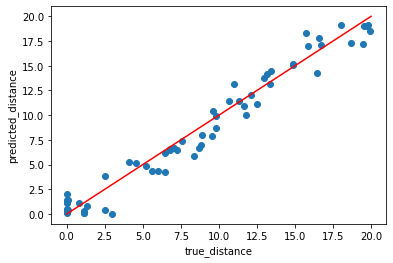

In [ ]:
print('xgboost prediction r2_score = %f' % r2_score(y_pred_xgb, test_label))
print('xgboost prediction mean_absolute_error = %f' % mean_absolute_error(y_pred_xgb, test_label))
plt.scatter(test_label, y_pred_xgb)
plt.plot(np.linspace(0, cap, 150), np.linspace(0, cap, 150), c='r')
plt.xlabel('true_distance')
plt.ylabel('predicted_distance')

In [ ]:
ridge_regressor.fit(extracted_features_train, train_label)
y_pred_ridge = ridge_regressor.predict(extracted_features_test)

RidgeCV prediction r2_score = 0.688922
RidgeCV prediction mean_absolute_error = 2.739158


Text(0, 0.5, 'predicted_distance')

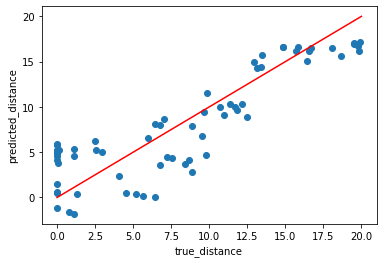

In [ ]:
print('RidgeCV prediction r2_score = %f' % r2_score(y_pred_ridge, test_label))
print('RidgeCV prediction mean_absolute_error = %f' % mean_absolute_error(y_pred_ridge, test_label))
plt.scatter(test_label, y_pred_ridge)
plt.plot(np.linspace(0, cap, 150), np.linspace(0, cap, 150), c='r')
plt.xlabel('true_distance')
plt.ylabel('predicted_distance')

In [ ]:
tf.random.set_seed(42)
supervise_history = supervise_model.fit(train_ds,
                 validation_data=test_ds,                      
                 batch_size=training_batch_size,                       
                 epochs=10,                                           
                 workers=8,                                            
                 use_multiprocessing=True,                             
                 verbose=1)                                         
                #  callbacks=[MetricsCheckpoint('small_supervise')])  

Epoch 1/10
21/21 [==============================] - 55s 2s/step - loss: 30.6404 - mae: 4.4466 - val_loss: 25.7785 - val_mae: 4.5040
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 27.6751 - mae: 4.4045

InvalidArgumentError: ignored